# Промышленность - задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Исследовательский анализ данных

In [1]:
# установим нужные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install shap
import shap
%matplotlib inline 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 572 kB 2.1 MB/s eta 0:00:01


In [2]:
# загрузим датасеты
df_arc = pd.read_csv('/datasets/data_arc_new.csv')
df_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
df_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
df_gas = pd.read_csv('/datasets/data_gas_new.csv')
df_temp = pd.read_csv('/datasets/data_temp_new.csv')
df_wire = pd.read_csv('/datasets/data_wire_new.csv')
df_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

In [3]:
# создадим функцию, которая покажет всю общую информацию о датасете
def show_info(df_name):  
    display(df_name.head(10))
    print('-------------------------------------------')
    print(df_name.info())
    print('-------------------------------------------')
    print('Количество пропусков:', df_name.isna().sum())
    print('-------------------------------------------')
    print('Количество дубликатов:', df_name.duplicated().sum())
    print('-------------------------------------------')
    print(df_name.describe())
    print('-------------------------------------------')
    df_name.hist(figsize=(15, 20));

### Данные об электродах

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
-------------------------------------------
Количество пропусков: key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64
-------------------------------------------
Количество дубликатов: 0
-------------------------------------------
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000  

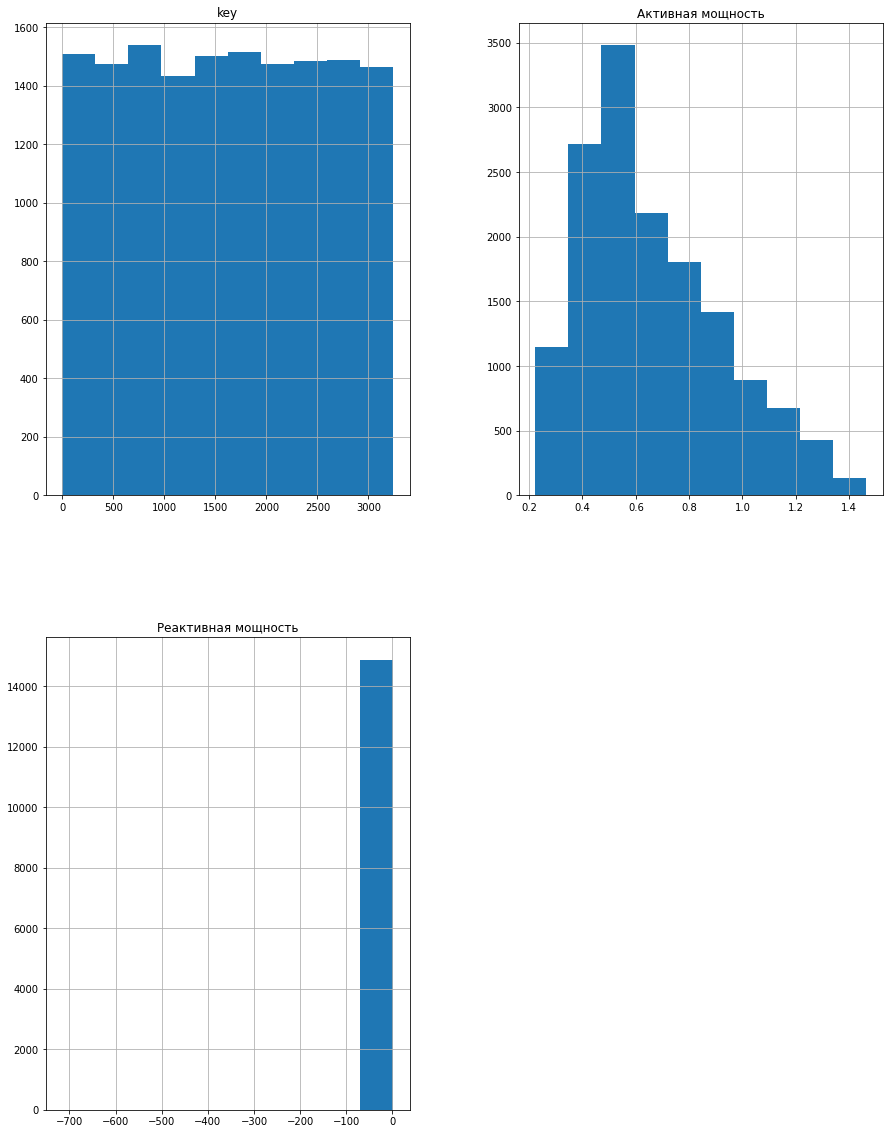

In [4]:
# посмотрим на датасет
show_info(df_arc)

In [5]:
# исправим названия столбцов
df_arc.columns = ['key', 'start_arc_heating', 'end_arc_heating', 'active_power', 'reactive_power']

In [6]:
# приведём столбцы с датами к верному формату
df_arc['start_arc_heating'] = pd.to_datetime(df_arc['start_arc_heating'])
df_arc['end_arc_heating'] = pd.to_datetime(df_arc['end_arc_heating'])

In [7]:
# у реактивной мощности есть отрицательное значение. Проверим. Возможно выброс.
df_arc[df_arc['reactive_power'] == -715.479924]

,key,start_arc_heating,end_arc_heating,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [8]:
# проверим всю партию
df_arc[df_arc['key'] == 2116]

,key,start_arc_heating,end_arc_heating,active_power,reactive_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


В датасете обнаружена аномалия, которую необходимо исправить. Это можно попытаться сделать, узнав соотношение активной мощности и реактивной. Уточним связь данных признокав и если связь будет сильной, то найдем коэффициент отношения мощностей.

In [9]:
# проверим предыдущую партию
df_arc[df_arc['key'] == 2115]

,key,start_arc_heating,end_arc_heating,active_power,reactive_power
9775,2115,2019-07-28 01:38:20,2019-07-28 01:40:18,0.560170,0.435785
9776,2115,2019-07-28 01:46:45,2019-07-28 01:49:09,0.343438,0.230592
9777,2115,2019-07-28 01:58:40,2019-07-28 01:59:41,0.707937,0.460147


In [10]:
# найдем корреляцию признаков
round(df_arc.iloc[9775:9778]['reactive_power'].corr(df_arc.iloc[9775:9778]['active_power']), 2)

0.95

In [11]:
# рассчитаем коэффициент отношения 
coef = sum(df_arc.iloc[9775:9778]['reactive_power'] / df_arc.iloc[9775:9778]['active_power']) / 3
print(coef)

0.6997856044322935


In [12]:
# теперь исправим нашу аномалию
df_arc.at[9780, 'reactive_power'] = df_arc.iloc[9780]['active_power'] * coef

In [13]:
# проверим изменения
df_arc[df_arc['key'] == 2116]

,key,start_arc_heating,end_arc_heating,active_power,reactive_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,0.493590
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


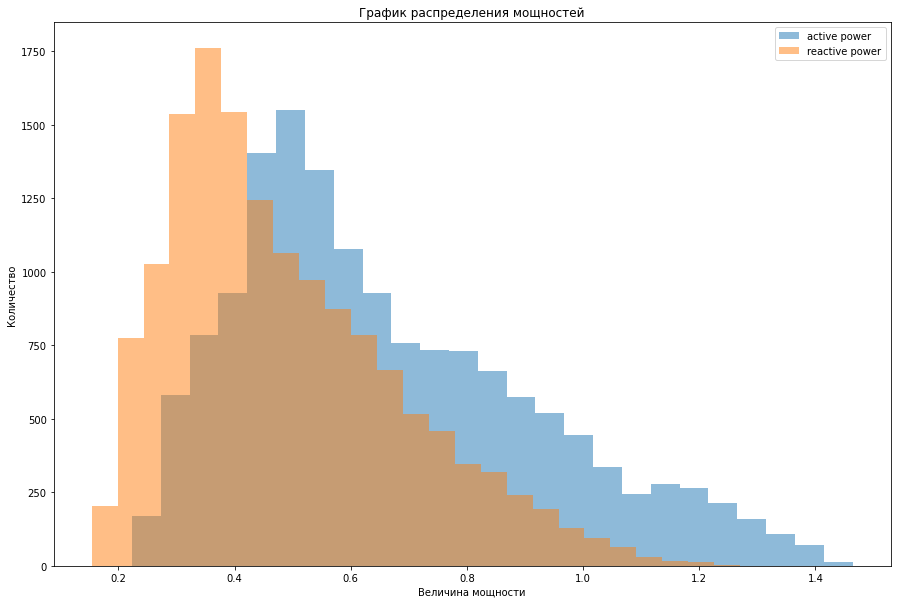

In [14]:
# аномалий нет, значит можем посмотреть признаки на графике
plt.subplots(figsize=(15, 10))
plt.hist(df_arc['active_power'], bins=25, alpha = 0.5, label='active power')
plt.hist(df_arc['reactive_power'], bins=25, alpha = 0.5, label='reactive power')
plt.title('График распределения мощностей')
plt.xlabel('Величина мощности')
plt.ylabel('Количество')
plt.legend()
plt.show()

,key,start_arc_heating,end_arc_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                14876 non-null  int64         
 1   start_arc_heating  14876 non-null  datetime64[ns]
 2   end_arc_heating    14876 non-null  datetime64[ns]
 3   active_power       14876 non-null  float64       
 4   reactive_power     14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
None
-------------------------------------------
Количество пропусков: key                  0
start_arc_heating    0
end_arc_heating      0
active_power         0
reactive_power       0
dtype: int64
-------------------------------------------
Количество дубликатов: 0
-------------------------------------------
                key  active_power  reactive_power
count  14876.000000  14876.000

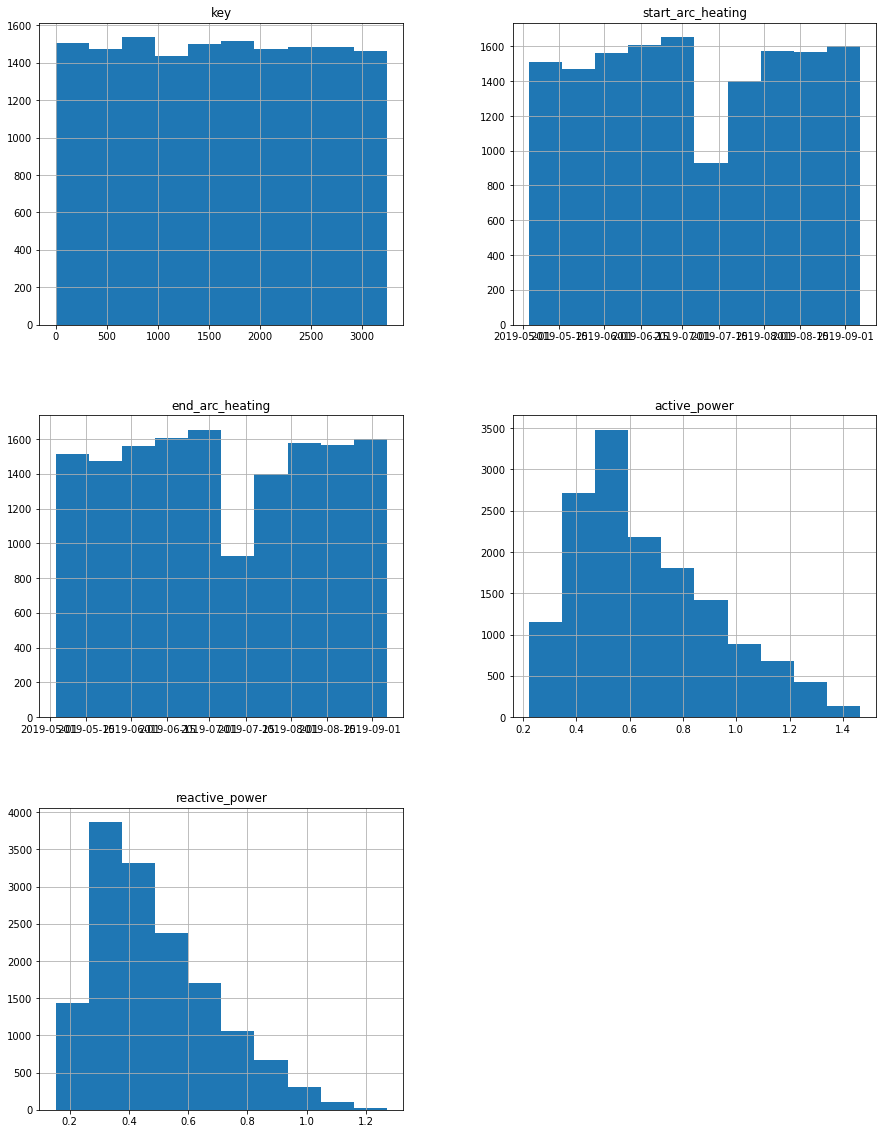

In [15]:
# еще раз посмотрим на датасет, но уже после изменений
show_info(df_arc)

### Данные о подаче сыпучих материалов (объём и время)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
-------------------------------------------
Количество пропусков: key           0
Bulk 1     2877
Bulk 2   

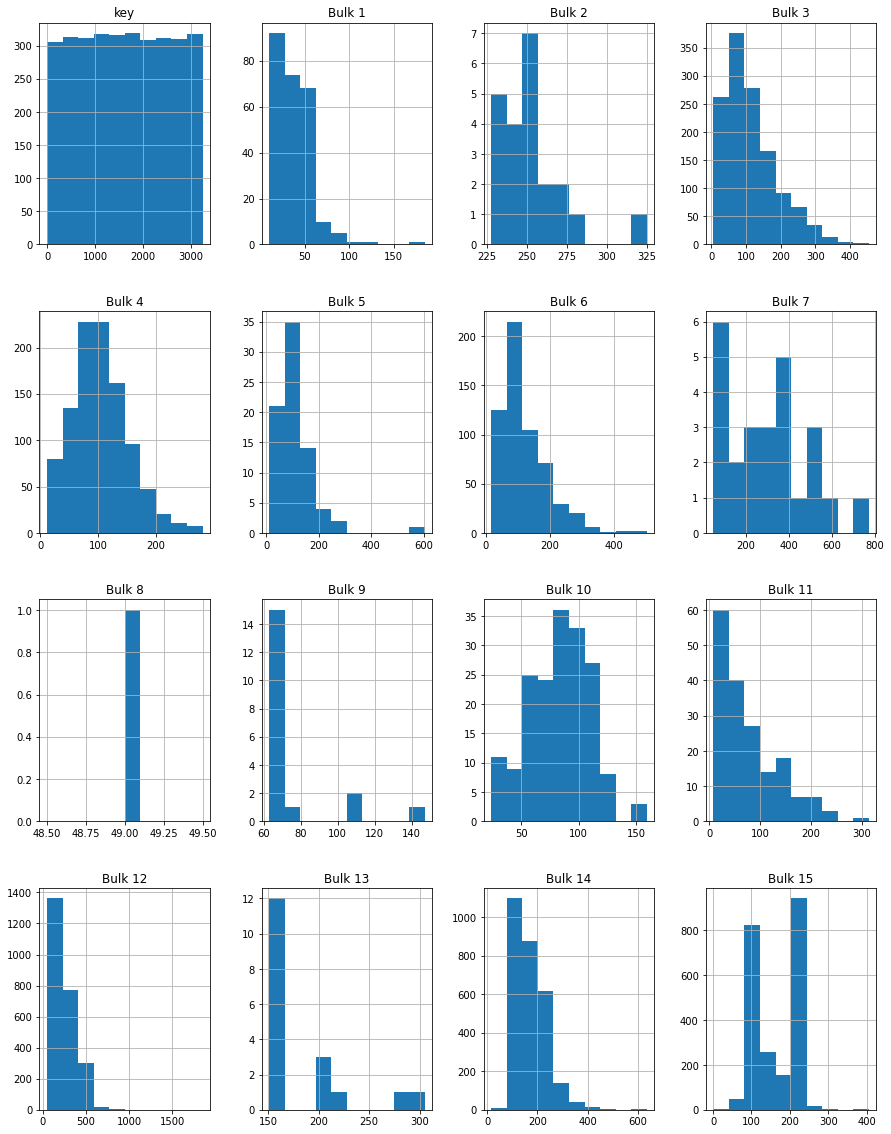

In [16]:
# посмотрим на датасет об объеме подачи сыпучих материалов
show_info(df_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None
-------------------------------------------
Количество пропусков: key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     

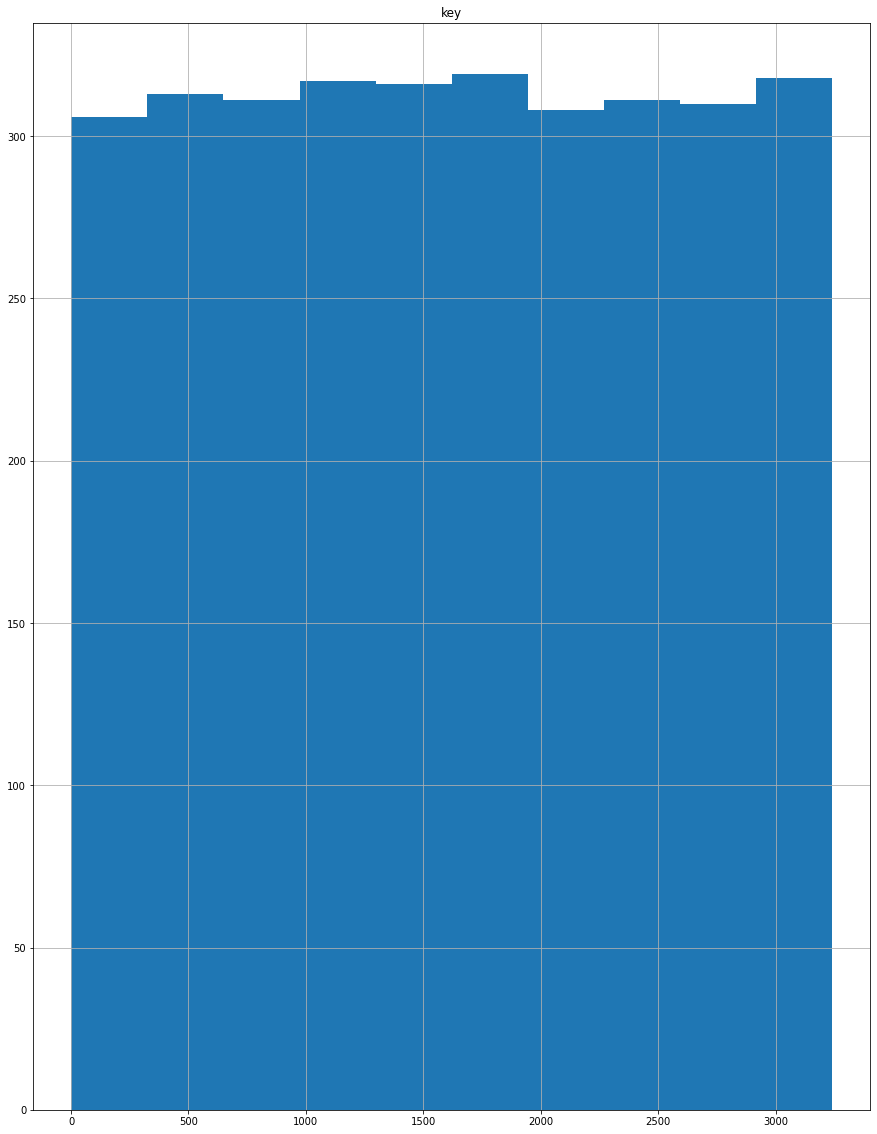

In [17]:
# посмотрим на датасет о времени подачи сыпучих материалов
show_info(df_bulk_time)

In [18]:
# приведем названия столбцов в датасетак в нормальный вид
df_bulk.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 
                     'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
df_bulk_time.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 
                          'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

In [19]:
# посмотрим количество не пустых значений в столбцах датасетов
print(df_bulk.count().sort_values(ascending=False))
print('-----------------------------')
print(df_bulk_time.count().sort_values(ascending=False))

key        3129
bulk_14    2806
bulk_12    2450
bulk_15    2248
bulk_3     1298
bulk_4     1014
bulk_6      576
bulk_1      252
bulk_11     177
bulk_10     176
bulk_5       77
bulk_7       25
bulk_2       22
bulk_9       19
bulk_13      18
bulk_8        1
dtype: int64
-----------------------------
key        3129
bulk_14    2806
bulk_12    2450
bulk_15    2248
bulk_3     1298
bulk_4     1014
bulk_6      576
bulk_1      252
bulk_11     177
bulk_10     176
bulk_5       77
bulk_7       25
bulk_2       22
bulk_9       19
bulk_13      18
bulk_8        1
dtype: int64


In [20]:
# удалим столбцы, в которых очень много пропусков
df_bulk_new = df_bulk.drop(columns=['bulk_8', 'bulk_13', 'bulk_9', 'bulk_2', 'bulk_7', 'bulk_5', 'bulk_10', 'bulk_11',
                                         'bulk_1'], axis=1)
df_bulk_time_new = df_bulk_time.drop(columns=['bulk_8', 'bulk_13', 'bulk_9', 'bulk_2', 'bulk_7', 'bulk_5', 'bulk_10', 
                                                   'bulk_11', 'bulk_1'], axis=1)

In [21]:
# создадим функцию для объединения датафреймов
def merge_df(df_1, df_2):
    df_1_new = df_1.set_index('key').stack().reset_index()
    df_2_new = df_2.set_index('key').stack().reset_index()
    df_merge = df_2_new.merge(df_1_new, on=['key', 'level_1'])
    df_merge.columns = ['key', 'variable', 'datetime', 'value']
    return df_merge

In [22]:
# теперь объединим датасеты
df_bulk_all = merge_df(df_bulk_new, df_bulk_time_new)
print(df_bulk_all)

        key variable             datetime  value
0         1   bulk_4  2019-05-03 11:28:48   43.0
1         1  bulk_12  2019-05-03 11:24:31  206.0
2         1  bulk_14  2019-05-03 11:14:50  150.0
3         1  bulk_15  2019-05-03 11:10:43  154.0
4         2   bulk_4  2019-05-03 11:36:50   73.0
...     ...      ...                  ...    ...
10387  3240   bulk_6  2019-09-06 16:24:28   26.0
10388  3240  bulk_14  2019-09-06 16:07:29  192.0
10389  3240  bulk_15  2019-09-06 16:01:34   54.0
10390  3241  bulk_14  2019-09-06 17:26:33  180.0
10391  3241  bulk_15  2019-09-06 17:23:15   52.0

[10392 rows x 4 columns]


,key,variable,datetime,value
0,1,bulk_4,2019-05-03 11:28:48,43.0
1,1,bulk_12,2019-05-03 11:24:31,206.0
2,1,bulk_14,2019-05-03 11:14:50,150.0
3,1,bulk_15,2019-05-03 11:10:43,154.0
4,2,bulk_4,2019-05-03 11:36:50,73.0
5,2,bulk_12,2019-05-03 11:53:30,206.0
6,2,bulk_14,2019-05-03 11:48:37,149.0
7,2,bulk_15,2019-05-03 11:44:39,154.0
8,3,bulk_4,2019-05-03 12:32:39,34.0
9,3,bulk_12,2019-05-03 12:27:13,205.0


-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10392 entries, 0 to 10391
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   key       10392 non-null  int64  
 1   variable  10392 non-null  object 
 2   datetime  10392 non-null  object 
 3   value     10392 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 405.9+ KB
None
-------------------------------------------
Количество пропусков: key         0
variable    0
datetime    0
value       0
dtype: int64
-------------------------------------------
Количество дубликатов: 0
-------------------------------------------
                key         value
count  10392.000000  10392.000000
mean    1635.381062    173.111913
std      939.267996     96.456857
min        1.000000      1.000000
25%      819.750000    104.000000
50%     1636.000000    155.000000
75%     2454.000000    207.000000
max     3241.000000   184

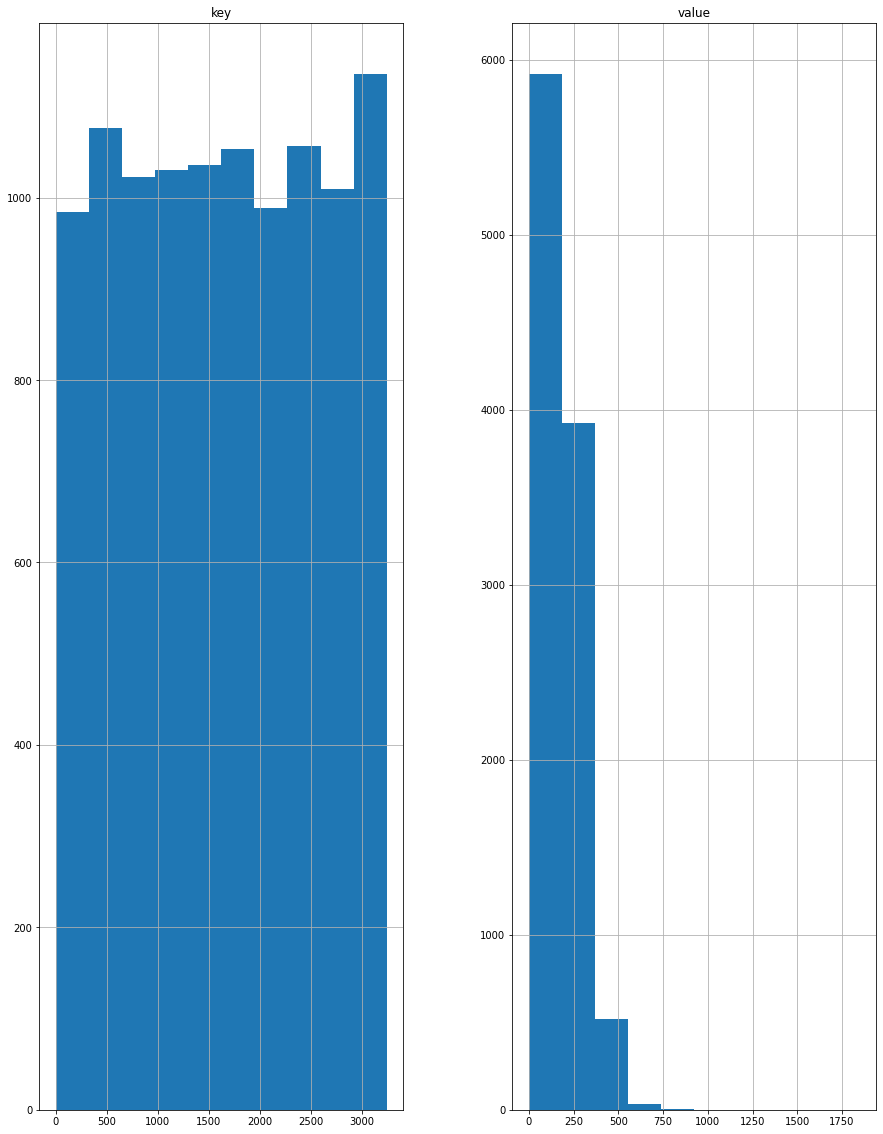

In [23]:
# посмотрим на созданный общий датасет
show_info(df_bulk_all)

In [24]:
# исправим типы данных
df_bulk_all['datetime'] = pd.to_datetime(df_bulk_all['datetime'])
df_bulk_all['value'] = df_bulk_all['value'].astype('int')

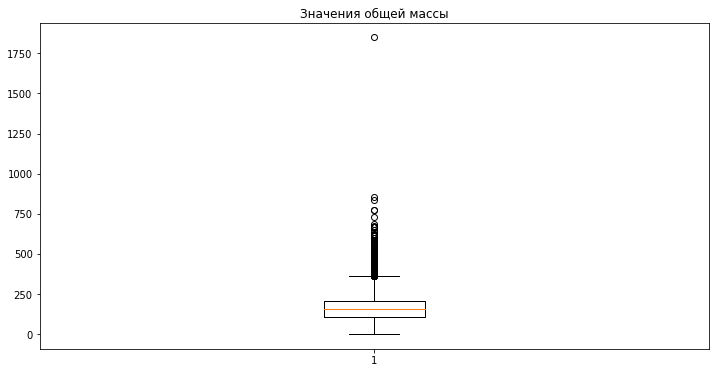

In [25]:
# теперь посмотрим на выброс, который является максимальным значением объема подачи сыпучих материалов
plt.figure(figsize=(12, 6))
plt.boxplot(df_bulk_all['value'])
plt.title('Значения общей массы')
plt.show()

In [26]:
# избавимся от выброса
df_bulk_all = df_bulk_all.query('value < 1000')

,key,variable,datetime,value
0,1,bulk_4,2019-05-03 11:28:48,43
1,1,bulk_12,2019-05-03 11:24:31,206
2,1,bulk_14,2019-05-03 11:14:50,150
3,1,bulk_15,2019-05-03 11:10:43,154
4,2,bulk_4,2019-05-03 11:36:50,73
5,2,bulk_12,2019-05-03 11:53:30,206
6,2,bulk_14,2019-05-03 11:48:37,149
7,2,bulk_15,2019-05-03 11:44:39,154
8,3,bulk_4,2019-05-03 12:32:39,34
9,3,bulk_12,2019-05-03 12:27:13,205


-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10391 entries, 0 to 10391
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   key       10391 non-null  int64         
 1   variable  10391 non-null  object        
 2   datetime  10391 non-null  datetime64[ns]
 3   value     10391 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 405.9+ KB
None
-------------------------------------------
Количество пропусков: key         0
variable    0
datetime    0
value       0
dtype: int64
-------------------------------------------
Количество дубликатов: 0
-------------------------------------------
                key         value
count  10391.000000  10391.000000
mean    1635.507458    172.950630
std      939.224809     95.049866
min        1.000000      1.000000
25%      820.500000    104.000000
50%     1636.000000    155.000000
75%     24

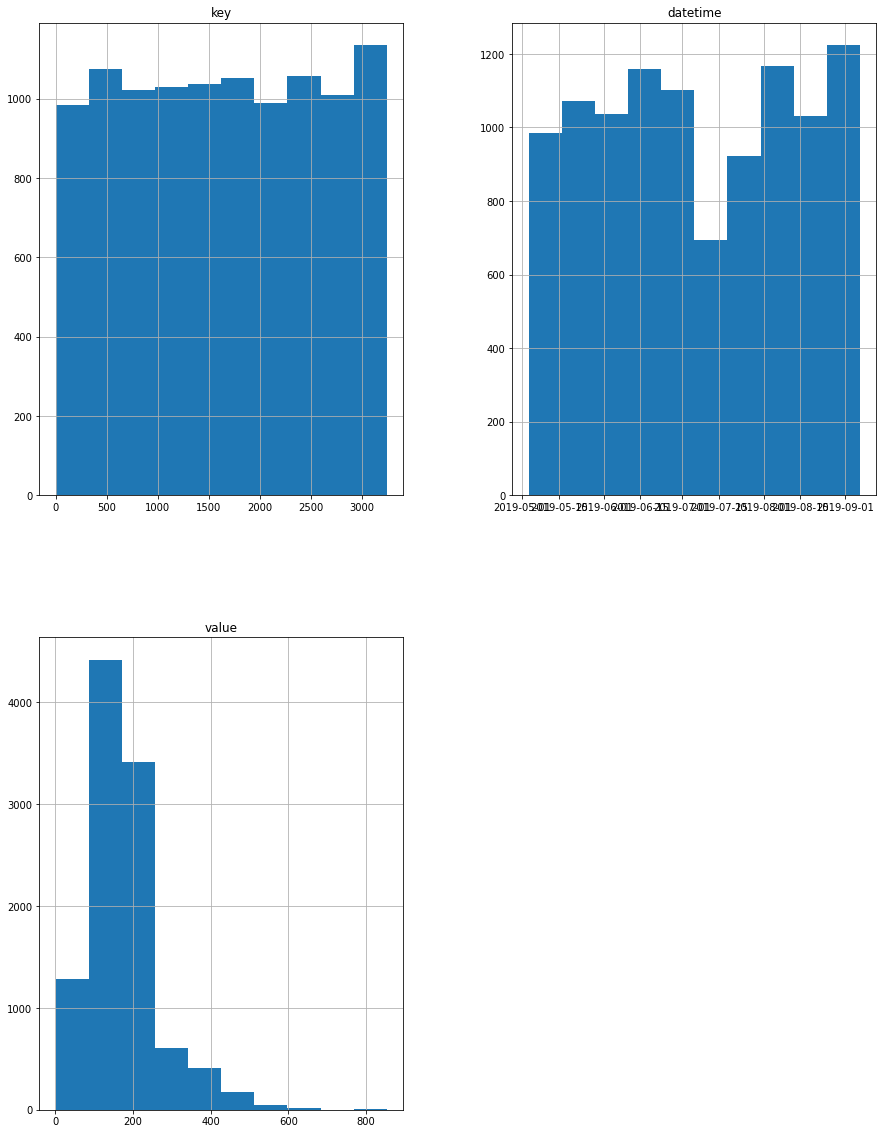

In [27]:
# проверим общий датасет после изменений
show_info(df_bulk_all)

### Данные о продувке сплава газом

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
-------------------------------------------
Количество пропусков: key      0
Газ 1    0
dtype: int64
-------------------------------------------
Количество дубликатов: 0
-------------------------------------------
               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040
-------------------------------------------


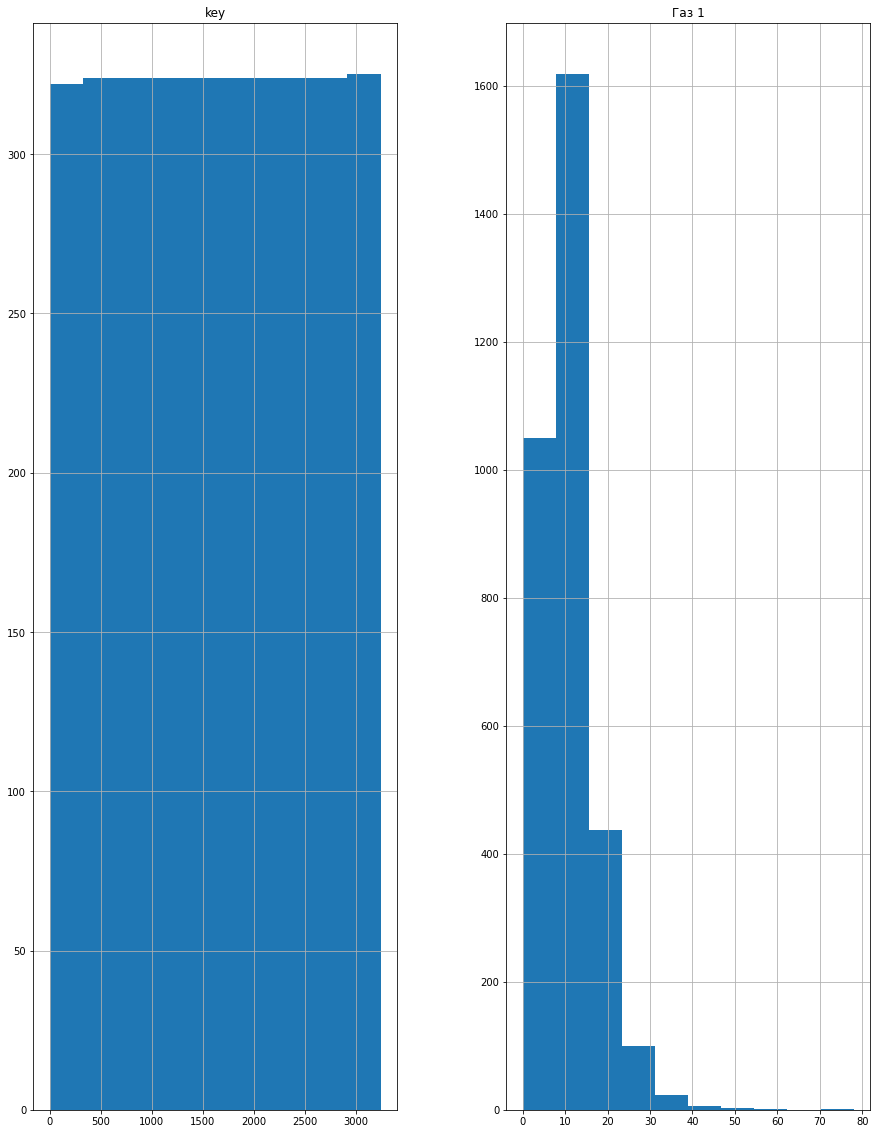

In [28]:
# посмотрим на датасет
show_info(df_gas)

In [29]:
# исправим названия столбцов на корректные
df_gas.columns = ['key', 'gas']

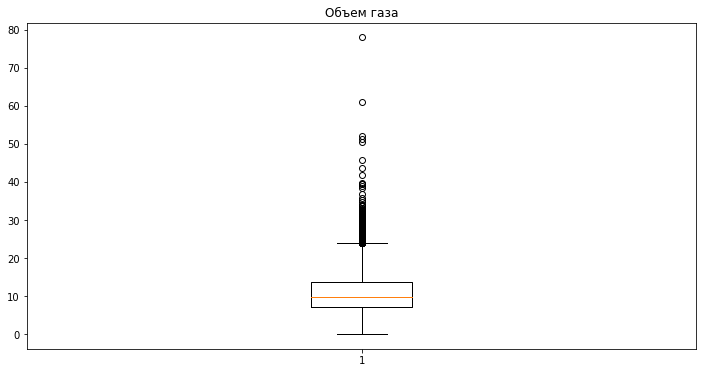

In [30]:
# типы корректные, пропусков нет, посмотрим на выбросы
plt.figure(figsize=(12, 6))
plt.boxplot(df_gas['gas'])
plt.title('Объем газа')
plt.show()

In [31]:
# избавимся от выбросов
df_gas = df_gas.query('gas < 65')

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3238 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3238 non-null   int64  
 1   gas     3238 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 75.9 KB
None
-------------------------------------------
Количество пропусков: key    0
gas    0
dtype: int64
-------------------------------------------
Количество дубликатов: 0
-------------------------------------------
               key          gas
count  3238.000000  3238.000000
mean   1622.262817    10.981372
std     935.251705     6.108806
min       1.000000     0.008399
25%     813.250000     7.042678
50%    1622.500000     9.832531
75%    2431.750000    13.767791
max    3241.000000    60.935689
-------------------------------------------


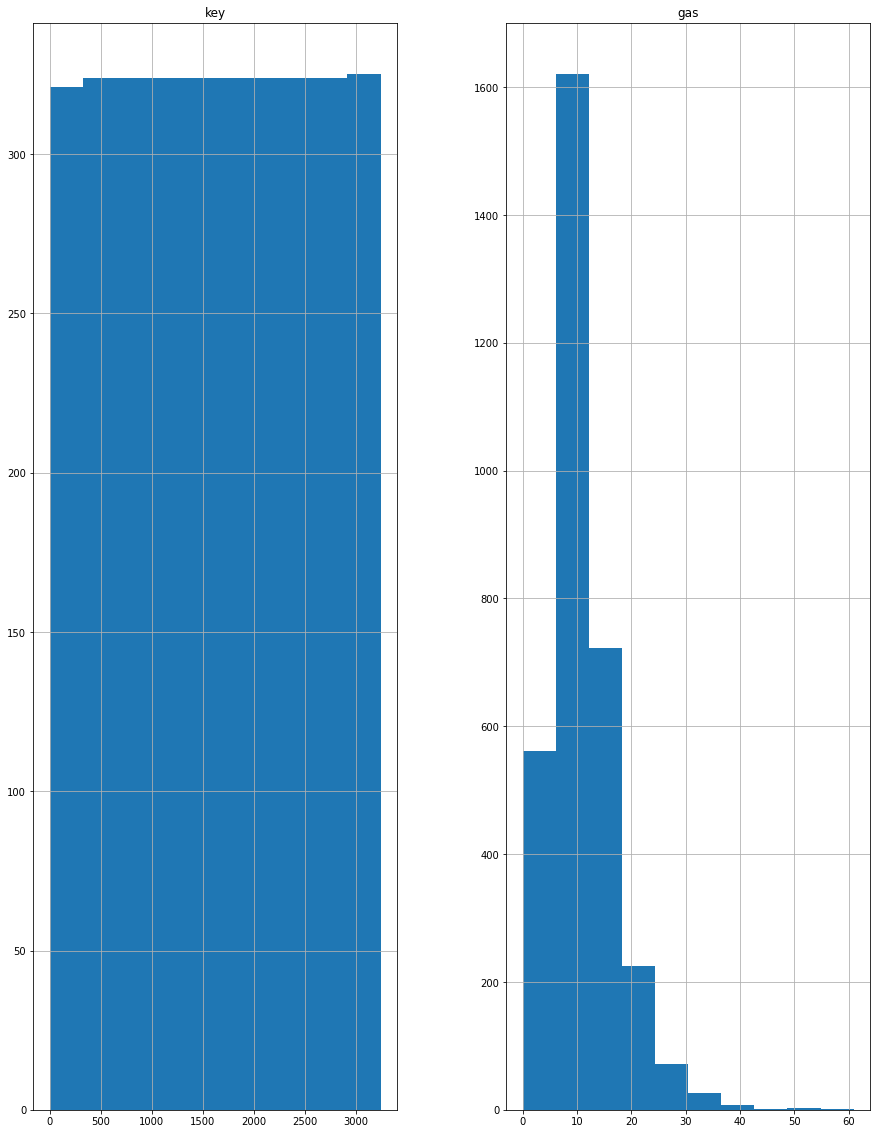

In [32]:
# посмотрим на очищеный датасет
show_info(df_gas)

### Результаты измерения температуры

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None
-------------------------------------------
Количество пропусков: key                0
Время замера       0
Температура     3427
dtype: int64
-------------------------------------------
Количество дубликатов: 0
-------------------------------------------
                key   Температура
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000
---

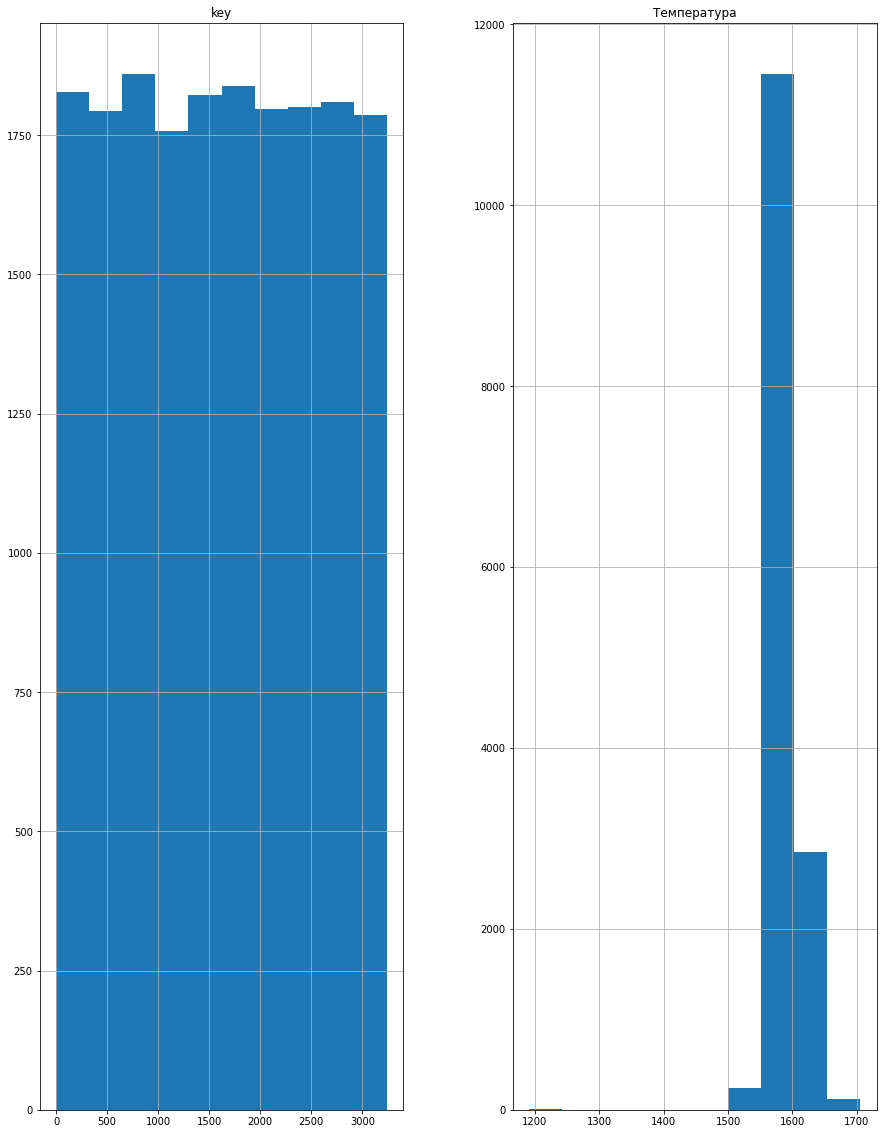

In [33]:
# посмотрим на датасет
show_info(df_temp)

In [34]:
# присвоим корректные названия столбцам и исправим типы данных
df_temp.columns = ['key', 'measurement_time', 'temperature']
df_temp['measurement_time'] = pd.to_datetime(df_temp['measurement_time'])

В данных довольно много пропусков. Заполнять нулевыи, средним значением или модой мы не можем, т.к. это сильно исказит данные. Нам остается только их удалить, но с учетом замеров по партиям. Если в партии есть хотябы один пропуск, то удалить нужно всю партию. Для начала найдем число таких партий.

In [35]:
df_temp_gr = df_temp.groupby('key').count()
df_temp_gr

,measurement_time,temperature
key,,
1,6,6
2,5,5
3,6,6
4,5,5
5,5,5
...,...,...
3237,6,1
3238,4,1
3239,9,1


In [36]:
df_temp_gr['del'] = df_temp_gr['temperature']/df_temp_gr['measurement_time']
df_temp_gr

,measurement_time,temperature,del
key,,,
1,6,6,1.000000
2,5,5,1.000000
3,6,6,1.000000
4,5,5,1.000000
5,5,5,1.000000
...,...,...,...
3237,6,1,0.166667
3238,4,1,0.250000
3239,9,1,0.111111


In [37]:
print('Количество партий с пропусками:', len(df_temp_gr[df_temp_gr['del'] < 1]))

Количество партий с пропусками: 739


In [38]:
# теперь удалим строки в нашем датасете с партиями, в которых были пропуски
df_temp = df_temp[df_temp['key'].isin(df_temp_gr[df_temp_gr['del'] == 1].index)]
df_temp

,key,measurement_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0


In [39]:
df_temp['temperature'] = df_temp['temperature'].astype('int')

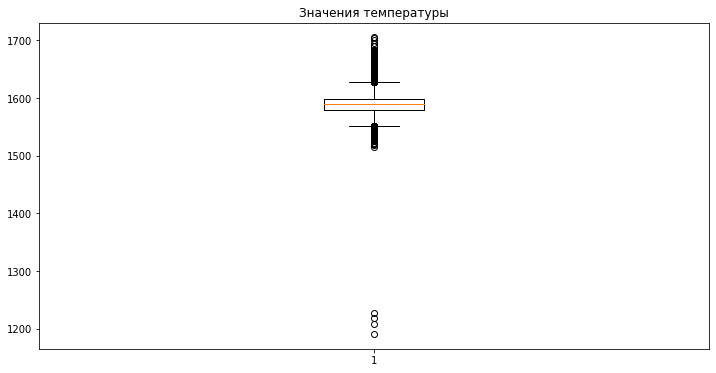

In [40]:
# теперь типы корректные, пропусков нет, посмотрим на выбросы
plt.figure(figsize=(12, 6))
plt.boxplot(df_temp['temperature'])
plt.title('Значения температуры')
plt.show()

На графике мы видим выбросы (значения ниже 1300). Температура плавления стали колеблется от 1350 до 1600, но в зависимости от вида сплава может быть и выше. Но избавляться от этих выбросов мы не будем, т.к. точно не зннаем какой был сплав, какой этап выплавки, возможно замеры проходили в самом конце, когда сталь нужно просто держать в разогретом состоянии.

,key,measurement_time,temperature
0,1,2019-05-03 11:02:04,1571
1,1,2019-05-03 11:07:18,1604
2,1,2019-05-03 11:11:34,1618
3,1,2019-05-03 11:18:04,1601
4,1,2019-05-03 11:25:59,1606
5,1,2019-05-03 11:30:38,1613
6,2,2019-05-03 11:34:04,1581
7,2,2019-05-03 11:38:40,1577
8,2,2019-05-03 11:46:09,1589
9,2,2019-05-03 11:49:38,1604


-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13926 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               13926 non-null  int64         
 1   measurement_time  13926 non-null  datetime64[ns]
 2   temperature       13926 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 435.2 KB
None
-------------------------------------------
Количество пропусков: key                 0
measurement_time    0
temperature         0
dtype: int64
-------------------------------------------
Количество дубликатов: 0
-------------------------------------------
                key   temperature
count  13926.000000  13926.000000
mean    1243.530447   1590.802671
std      719.126684     19.845377
min        1.000000   1191.000000
25%      624.000000   1580.000000
50%     1246.000000   1590.000000
75%     1870.00000

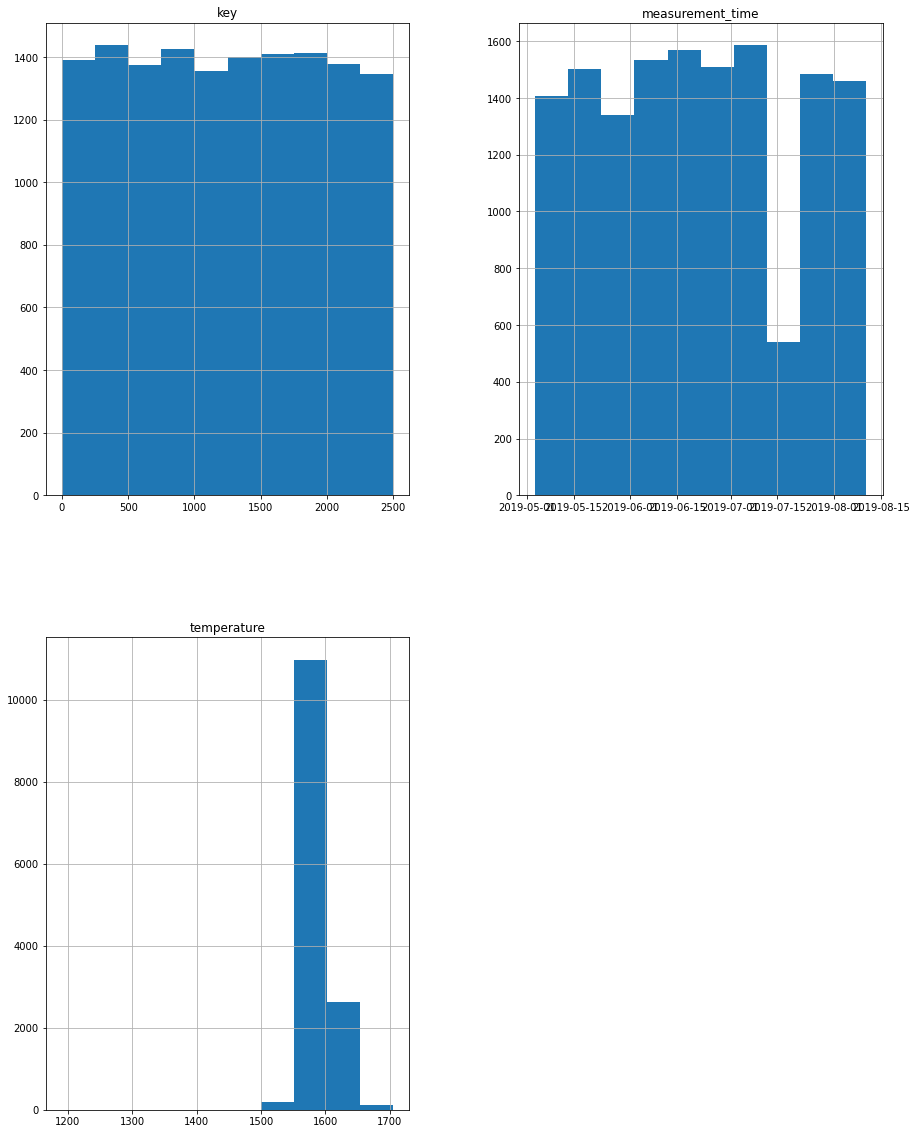

In [41]:
# еще раз посмотрим на датасет после изменений
show_info(df_temp)

### Данные о проволочных материалах (объем и время)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
-------------------------------------------
Количество пропусков: key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
-------------------------------------------
Количество дубликатов: 0
-------------------------------------------
      

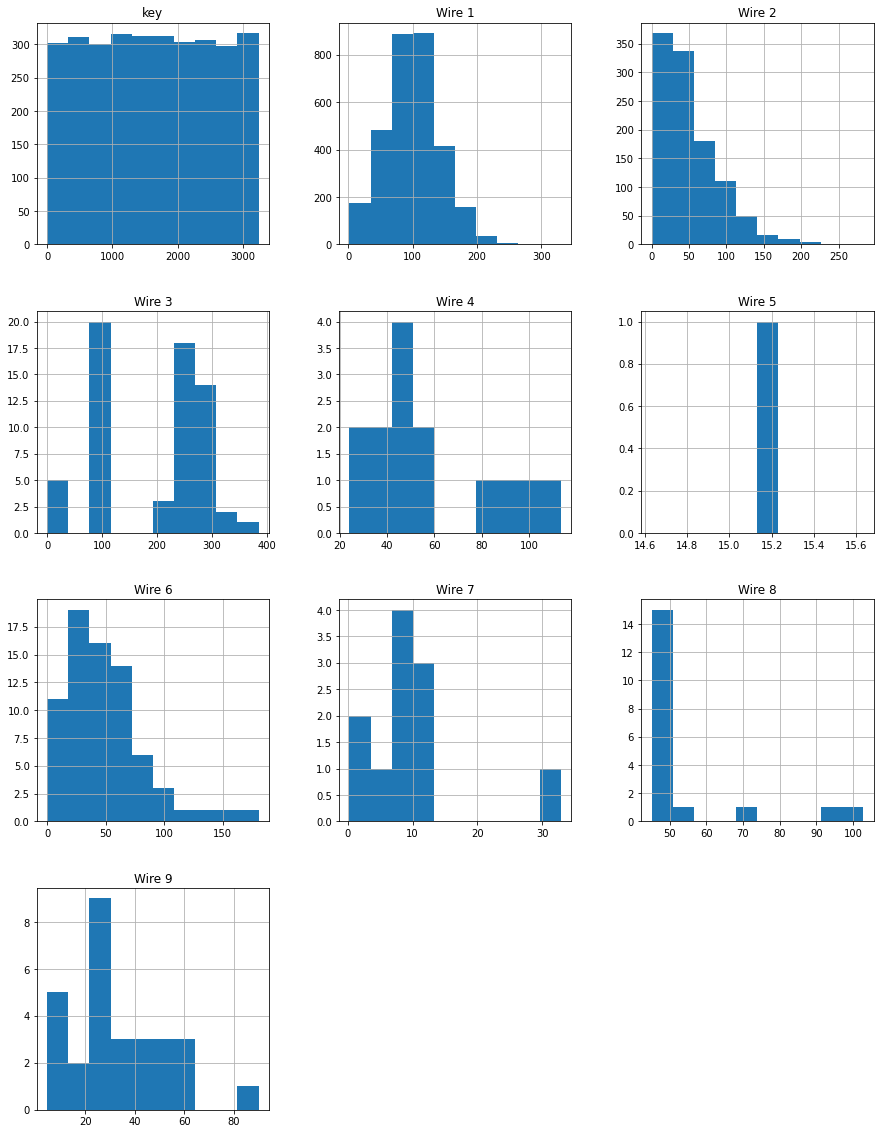

In [42]:
# посмотрим на датасет об объеме проволочных материалов
show_info(df_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
-------------------------------------------
Количество пропусков: key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
-------------------------------------------
Количество дубликатов: 0
-------------------------------------------
               key

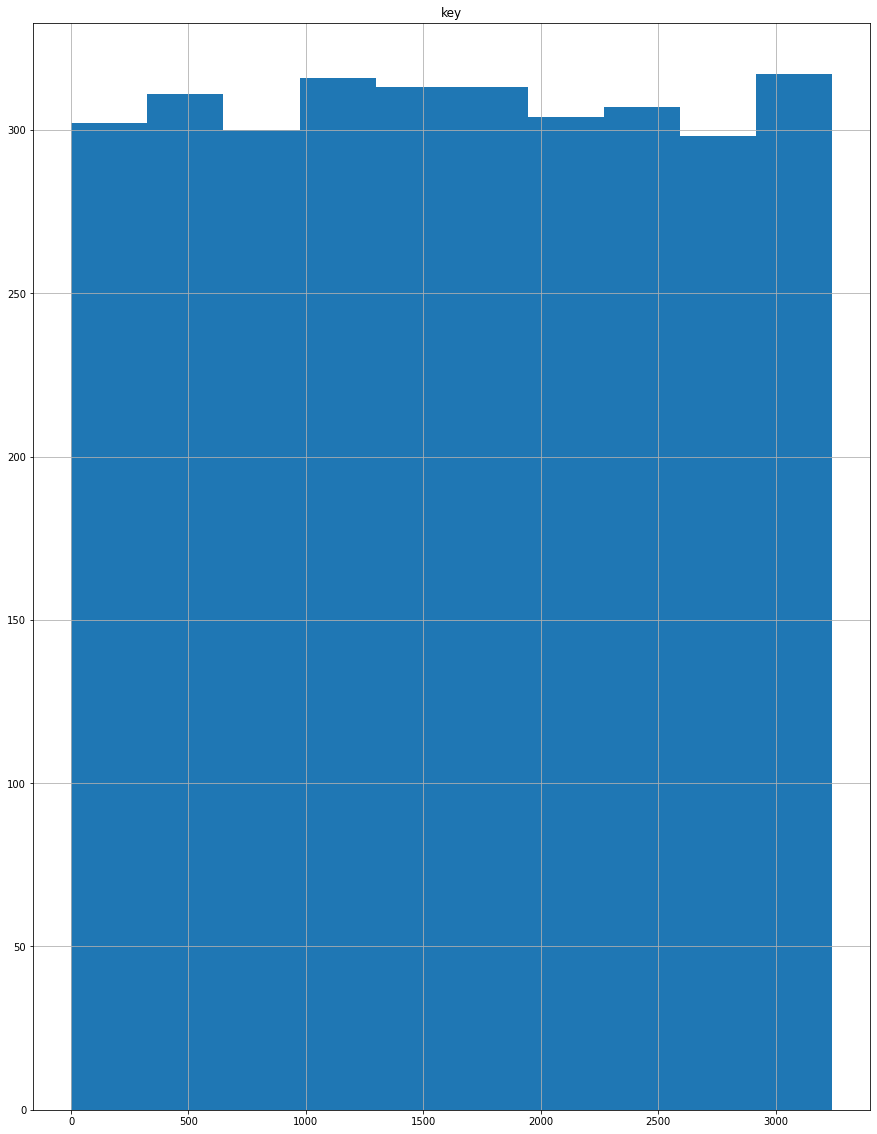

In [43]:
# посмотрим на датасет о времени проволочных материалов
show_info(df_wire_time)

In [44]:
# исправим названия столбцов в датасетах
df_wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']
df_wire_time.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

In [45]:
# посмотрим количество не пустых значений в столбцах датасетов
print(df_wire.count().sort_values(ascending=False))
print('-----------------------------')
print(df_wire_time.count().sort_values(ascending=False))

key       3081
wire_1    3055
wire_2    1079
wire_6      73
wire_3      63
wire_9      29
wire_8      19
wire_4      14
wire_7      11
wire_5       1
dtype: int64
-----------------------------
key       3081
wire_1    3055
wire_2    1079
wire_6      73
wire_3      63
wire_9      29
wire_8      19
wire_4      14
wire_7      11
wire_5       1
dtype: int64


In [46]:
# удалим столбцы, в которых слишком много пропусков
df_wire_new = df_wire.drop(columns=['wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9'], axis=1)
df_wire_time_new = df_wire_time.drop(columns=['wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9'], axis=1)

In [47]:
# объединим датасеты с помощью написанной ранее функции
df_wire_all = merge_df(df_wire_new, df_wire_time_new)
print(df_wire_all)

       key variable             datetime       value
0        1   wire_1  2019-05-03 11:06:19   60.059998
1        2   wire_1  2019-05-03 11:36:50   96.052315
2        3   wire_1  2019-05-03 12:11:46   91.160157
3        4   wire_1  2019-05-03 12:43:22   89.063515
4        5   wire_1  2019-05-03 13:20:44   89.238236
...    ...      ...                  ...         ...
4129  3237   wire_1  2019-09-06 11:33:38   38.088959
4130  3238   wire_1  2019-09-06 12:18:35   56.128799
4131  3239   wire_1  2019-09-06 14:36:11  143.357761
4132  3240   wire_1  2019-09-06 15:33:55   34.070400
4133  3241   wire_1  2019-09-06 17:10:06   63.117595

[4134 rows x 4 columns]


In [48]:
# присвоим корректный тип данных столбцу с датой и временем
df_wire_all['datetime'] = pd.to_datetime(df_wire_all['datetime'])

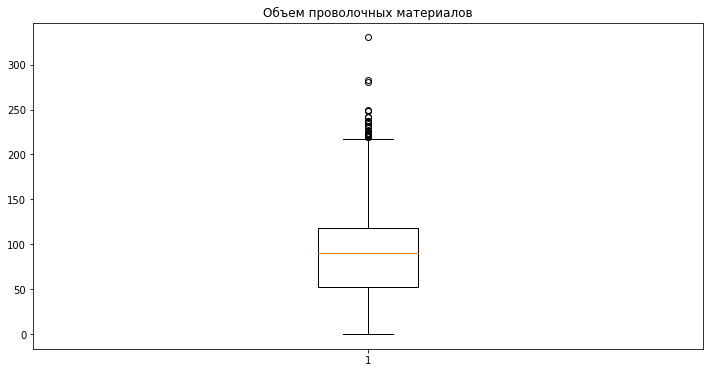

In [49]:
# теперь типы корректные. Посмотрим на выбросы
plt.figure(figsize=(12, 6))
plt.boxplot(df_wire_all['value'])
plt.title('Объем проволочных материалов')
plt.show()

In [50]:
# удалим очевидный выброс
df_wire_all = df_wire_all.query('value < 300')

,key,variable,datetime,value
0,1,wire_1,2019-05-03 11:06:19,60.059998
1,2,wire_1,2019-05-03 11:36:50,96.052315
2,3,wire_1,2019-05-03 12:11:46,91.160157
3,4,wire_1,2019-05-03 12:43:22,89.063515
4,5,wire_1,2019-05-03 13:20:44,89.238236
5,5,wire_2,2019-05-03 13:15:34,9.114560
6,6,wire_1,2019-05-03 13:57:27,99.109917
7,6,wire_2,2019-05-03 13:48:52,9.114560
8,7,wire_1,2019-05-03 14:18:58,98.061600
9,8,wire_1,2019-05-03 15:01:30,155.282394


-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4133 entries, 0 to 4133
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   key       4133 non-null   int64         
 1   variable  4133 non-null   object        
 2   datetime  4133 non-null   datetime64[ns]
 3   value     4133 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 161.4+ KB
None
-------------------------------------------
Количество пропусков: key         0
variable    0
datetime    0
value       0
dtype: int64
-------------------------------------------
Количество дубликатов: 0
-------------------------------------------
               key        value
count  4133.000000  4133.000000
mean   1634.339463    87.703713
std     931.709010    46.714957
min       1.000000     0.030160
25%     834.000000    52.066559
50%    1641.000000    90.068153
75%    2444.00

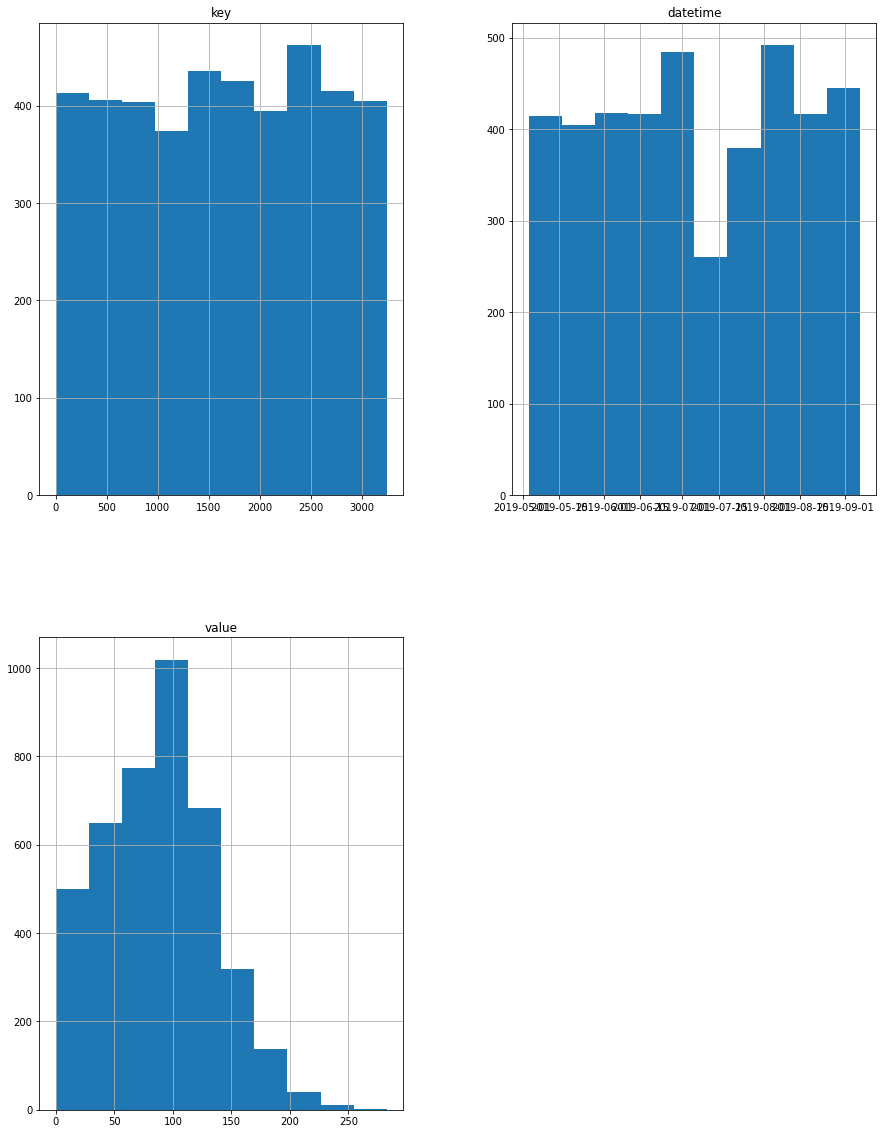

In [51]:
# посмотрим на общий датасет
show_info(df_wire_all)

### Выводы:

*Нам были даны семь датасетов с данными об электрода, о сыпучих и проволочных материалах, о продувке сплава газом и о измерениях температуры. При изучении данных пришлось решать проблемы с пропусками, выбросами, некорректными значениями, неправильными названиями столбцов, неправильными форматами данных. Но не в одном из датасетов не было дубликатов. Датасеты с информацией об объемах и времени нам удалось объединить. После внесения всех исправлений и корректировок мы имеем пять датасетов полностью готовых к дальнейшему проведению исследования.*

## Предобработка

Нам необходимо собрать один датасет с важными для исследования параметрами.

In [52]:
# сперва посмотрим еще раз на все датасеты и столбцы что в них есть
for df in [df_arc, df_bulk_all, df_gas, df_temp, df_wire_all]:
    print(df.query('key == 1'))
    print('\n')

   key   start_arc_heating     end_arc_heating  active_power  reactive_power
0    1 2019-05-03 11:02:14 2019-05-03 11:06:02      0.305130        0.211253
1    1 2019-05-03 11:07:28 2019-05-03 11:10:33      0.765658        0.477438
2    1 2019-05-03 11:11:44 2019-05-03 11:14:36      0.580313        0.430460
3    1 2019-05-03 11:18:14 2019-05-03 11:24:19      0.518496        0.379979
4    1 2019-05-03 11:26:09 2019-05-03 11:28:37      0.867133        0.643691


   key variable            datetime  value
0    1   bulk_4 2019-05-03 11:28:48     43
1    1  bulk_12 2019-05-03 11:24:31    206
2    1  bulk_14 2019-05-03 11:14:50    150
3    1  bulk_15 2019-05-03 11:10:43    154


   key        gas
0    1  29.749986


   key    measurement_time  temperature
0    1 2019-05-03 11:02:04         1571
1    1 2019-05-03 11:07:18         1604
2    1 2019-05-03 11:11:34         1618
3    1 2019-05-03 11:18:04         1601
4    1 2019-05-03 11:25:59         1606
5    1 2019-05-03 11:30:38         1613



In [53]:
# в датасете найдем дополнительный признак: продолжительность нагрева в секундах
df_arc['diff_time_heating'] = df_arc['end_arc_heating'] - df_arc['start_arc_heating']
df_arc['diff_time_heating'] = df_arc.apply(lambda row: (row['end_arc_heating'] - row['start_arc_heating']).total_seconds(),axis=1)
df_arc.head()

,key,start_arc_heating,end_arc_heating,active_power,reactive_power,diff_time_heating
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0


In [54]:
# теперь агрегируем по партии активную, реактивную мощность и время нагрева. Найдем их суммарные величины.
data_arc = df_arc.pivot_table(index=['key'], values=['active_power', 'reactive_power', 'diff_time_heating'], 
                              aggfunc=['sum']).reset_index().droplevel(1, axis=1)
data_arc.columns = ['key','sum_active_power', 'sum_time_heating', 'sum_reactive_power']
data_arc

,key,sum_active_power,sum_time_heating,sum_reactive_power
0,1,3.036730,1098.0,2.142821
1,2,2.139408,811.0,1.453357
2,3,4.063641,655.0,2.937457
3,4,2.706489,741.0,2.056992
4,5,2.252950,869.0,1.687991
...,...,...,...,...
3209,3237,2.541872,909.0,2.025417
3210,3238,1.374821,546.0,1.038103
3211,3239,4.848005,1216.0,3.541541
3212,3240,3.317679,839.0,2.373552


Итак у нас появились три признака для итогового датасета. Продолжим.

In [55]:
# теперь агрегируем по партии суммарный объем потребленного газа
data_gas = df_gas.pivot_table(index=['key'], values=['gas'], 
                              aggfunc=['sum']).reset_index().droplevel(1, axis=1)
data_gas.columns = ['key','sum_gas']
data_gas

,key,sum_gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3233,3237,5.543905
3234,3238,6.745669
3235,3239,16.023518
3236,3240,11.863103


In [56]:
# найдём минимальную, максимальную и среднюю температуры для каждой партии
data_temp = df_temp.pivot_table(index=['key'], values=['temperature'], 
                                aggfunc=['max', 'min', 'mean']).reset_index().droplevel(1, axis=1)
data_temp.columns = ['key', 'max_temp', 'min_temp', 'mean_temp']
data_temp

,key,max_temp,min_temp,mean_temp
0,1,1618,1571,1602.166667
1,2,1604,1577,1590.600000
2,3,1600,1596,1598.166667
3,4,1625,1601,1616.800000
4,5,1602,1576,1589.000000
...,...,...,...,...
2472,2495,1591,1570,1583.200000
2473,2496,1595,1554,1580.428571
2474,2497,1589,1571,1578.250000
2475,2498,1594,1570,1585.000000


In [57]:
# теперь выберем максимальное и минимальное время замера температуры для партий
data_temp_time = df_temp.pivot_table(index=['key'], values=['measurement_time'], 
                                     aggfunc=['max', 'min',]).reset_index().droplevel(1, axis=1)
data_temp_time.columns = ['key', 'max_time', 'min_time']
data_temp_time.head()

,key,max_time,min_time
0,1,2019-05-03 11:30:38,2019-05-03 11:02:04
1,2,2019-05-03 11:55:09,2019-05-03 11:34:04
2,3,2019-05-03 12:35:57,2019-05-03 12:06:44
3,4,2019-05-03 12:59:47,2019-05-03 12:39:27
4,5,2019-05-03 13:36:39,2019-05-03 13:11:03


In [58]:
# узнаем были ли однократные замеры
data_temp_time.query('max_time == min_time')

,key,max_time,min_time
192,195,2019-05-11 00:01:36,2019-05-11 00:01:36
276,279,2019-05-14 10:13:01,2019-05-14 10:13:01


In [59]:
# удалим их как не информативные
data_temp_time = data_temp_time.query('max_time != min_time')
data_temp_time.head()

,key,max_time,min_time
0,1,2019-05-03 11:30:38,2019-05-03 11:02:04
1,2,2019-05-03 11:55:09,2019-05-03 11:34:04
2,3,2019-05-03 12:35:57,2019-05-03 12:06:44
3,4,2019-05-03 12:59:47,2019-05-03 12:39:27
4,5,2019-05-03 13:36:39,2019-05-03 13:11:03


In [60]:
# теперь можем найти значения первой и последней температур
data_temp_first = df_temp[df_temp['measurement_time'].isin(data_temp_time['min_time'])]
data_temp_last = df_temp[df_temp['measurement_time'].isin(data_temp_time['max_time'])]
data_temp_all = data_temp_first.merge(data_temp_last, on='key')
data_temp_all = data_temp_all.drop(['measurement_time_x', 'measurement_time_y'], axis=1)
data_temp_all.columns = ['key', 'first_temp', 'last_temp']
data_temp_all

,key,first_temp,last_temp
0,1,1571,1613
1,2,1581,1602
2,3,1596,1599
3,4,1601,1625
4,5,1576,1602
...,...,...,...
2470,2495,1570,1591
2471,2496,1554,1591
2472,2497,1571,1589
2473,2498,1591,1594


Сейчас, когда мы нашли необходимые признаки и параметры, можем приступить к формированию единого датасета.

In [61]:
data_total_1 = data_temp_all.merge(data_temp, on='key')
data_total_2 = data_total_1.merge(data_arc, on='key')
data_total_3 = data_total_2.merge(data_gas, on='key')
data_total_4 = data_total_3.merge(df_bulk_new, on='key')
data_all = data_total_4.merge(df_wire_new, on='key')
data_all

,key,first_temp,last_temp,max_temp,min_temp,mean_temp,sum_active_power,sum_time_heating,sum_reactive_power,sum_gas,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,wire_1,wire_2
0,1,1571,1613,1618,1571,1602.166667,3.036730,1098.0,2.142821,29.749986,NaN,43.0,NaN,206.0,150.0,154.0,60.059998,NaN
1,2,1581,1602,1604,1577,1590.600000,2.139408,811.0,1.453357,12.555561,NaN,73.0,NaN,206.0,149.0,154.0,96.052315,NaN
2,3,1596,1599,1600,1596,1598.166667,4.063641,655.0,2.937457,28.554793,NaN,34.0,NaN,205.0,152.0,153.0,91.160157,NaN
3,4,1601,1625,1625,1601,1616.800000,2.706489,741.0,2.056992,18.841219,NaN,81.0,NaN,207.0,153.0,154.0,89.063515,NaN
4,5,1576,1602,1602,1576,1589.000000,2.252950,869.0,1.687991,5.413692,NaN,78.0,NaN,203.0,151.0,152.0,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,2495,1570,1591,1591,1570,1583.200000,3.168133,723.0,2.210936,7.125735,21.0,NaN,NaN,256.0,129.0,223.0,89.150879,NaN
2324,2496,1554,1591,1595,1554,1580.428571,4.174918,940.0,2.872031,9.412616,NaN,63.0,NaN,256.0,129.0,226.0,114.179527,NaN
2325,2497,1571,1589,1589,1571,1578.250000,3.605239,569.0,2.452092,6.271699,NaN,85.0,NaN,230.0,124.0,226.0,94.086723,9.04800
2326,2498,1591,1594,1594,1570,1585.000000,3.202310,750.0,2.239820,14.953657,90.0,NaN,NaN,206.0,129.0,207.0,118.110717,NaN


In [62]:
# в датасете есть пропуски и не верные форматы. Это нужно исправить.
data_all.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2327
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 2328 non-null   int64  
 1   first_temp          2328 non-null   int64  
 2   last_temp           2328 non-null   int64  
 3   max_temp            2328 non-null   int64  
 4   min_temp            2328 non-null   int64  
 5   mean_temp           2328 non-null   float64
 6   sum_active_power    2328 non-null   float64
 7   sum_time_heating    2328 non-null   float64
 8   sum_reactive_power  2328 non-null   float64
 9   sum_gas             2328 non-null   float64
 10  bulk_3              959 non-null    float64
 11  bulk_4              811 non-null    float64
 12  bulk_6              438 non-null    float64
 13  bulk_12             1811 non-null   float64
 14  bulk_14             2067 non-null   float64
 15  bulk_15             1699 non-null   float64
 16  wire_1

,key,first_temp,last_temp,max_temp,min_temp,mean_temp,sum_active_power,sum_time_heating,sum_reactive_power,sum_gas,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,wire_1,wire_2
0,1,1571,1613,1618,1571,1602.166667,3.036730,1098,2.142821,29.749986,0,43,0,206,150,154,60.059998,0.000000
1,2,1581,1602,1604,1577,1590.600000,2.139408,811,1.453357,12.555561,0,73,0,206,149,154,96.052315,0.000000
2,3,1596,1599,1600,1596,1598.166667,4.063641,655,2.937457,28.554793,0,34,0,205,152,153,91.160157,0.000000
3,4,1601,1625,1625,1601,1616.800000,2.706489,741,2.056992,18.841219,0,81,0,207,153,154,89.063515,0.000000
4,5,1576,1602,1602,1576,1589.000000,2.252950,869,1.687991,5.413692,0,78,0,203,151,152,89.238236,9.114560
5,6,1543,1596,1600,1543,1584.000000,2.725274,952,1.881313,11.273392,0,117,0,204,201,154,99.109917,9.114560
6,7,1586,1599,1599,1582,1592.200000,2.626877,673,1.960419,9.836267,0,117,0,204,152,154,98.061600,0.000000
7,8,1577,1598,1604,1577,1595.800000,2.678958,913,2.096952,15.171553,0,99,0,410,252,153,155.282394,0.000000
8,9,1587,1592,1597,1586,1590.000000,3.520820,625,2.527365,8.216623,0,117,0,107,99,203,113.393279,9.143681
9,10,1574,1593,1593,1574,1584.285714,3.118778,825,2.154941,6.529891,0,0,0,203,102,204,81.244796,12.376000


-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2327 entries, 0 to 2327
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 2327 non-null   int64  
 1   first_temp          2327 non-null   int64  
 2   last_temp           2327 non-null   int64  
 3   max_temp            2327 non-null   int64  
 4   min_temp            2327 non-null   int64  
 5   mean_temp           2327 non-null   float64
 6   sum_active_power    2327 non-null   float64
 7   sum_time_heating    2327 non-null   int64  
 8   sum_reactive_power  2327 non-null   float64
 9   sum_gas             2327 non-null   float64
 10  bulk_3              2327 non-null   int64  
 11  bulk_4              2327 non-null   int64  
 12  bulk_6              2327 non-null   int64  
 13  bulk_12             2327 non-null   int64  
 14  bulk_14             2327 non-null   int64  
 15  bulk_15    

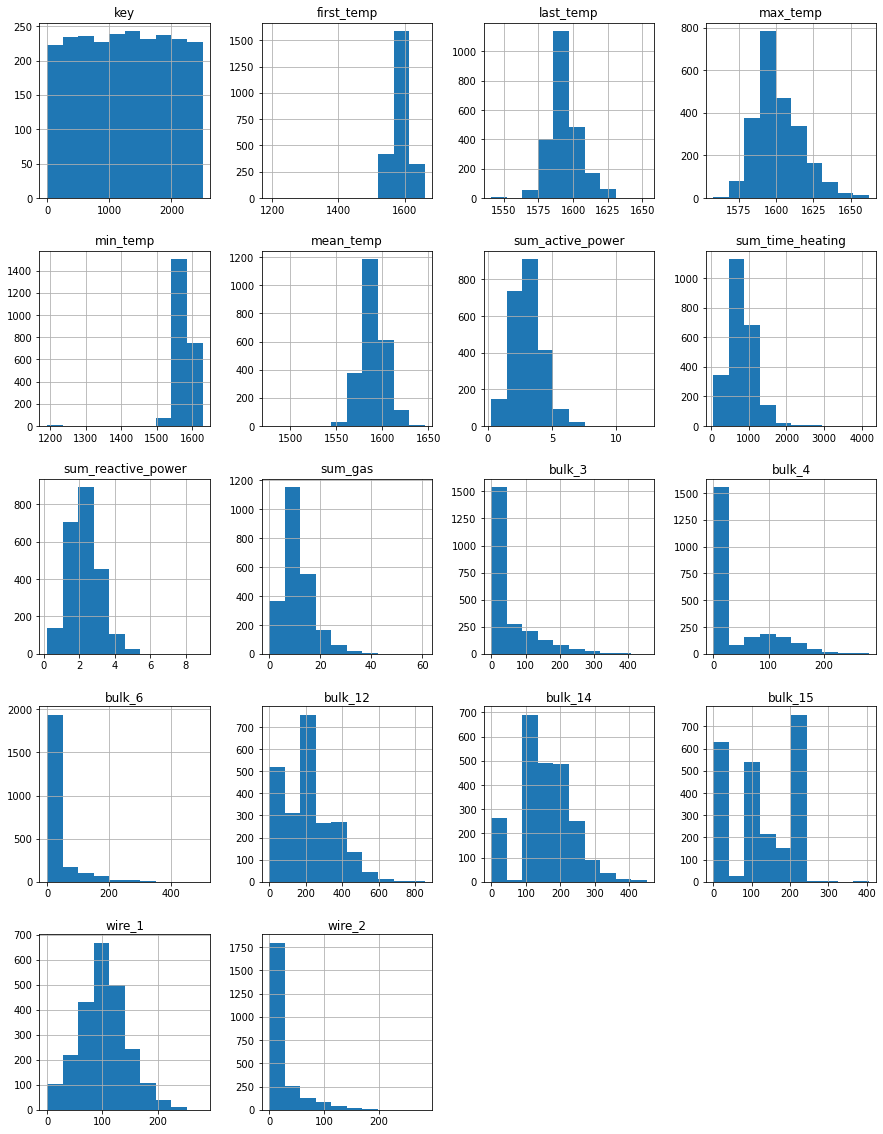

In [63]:
# заполним пропуски нулем
data_all = data_all.fillna(0)

# приведем столбцы в правильный формат
for i in data_all[['sum_time_heating', 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_12', 'bulk_14', 'bulk_15']]:
    data_all[i] = data_all[i].astype('int')

# ограничим выбросы для сыпучих материалов   
for i in data_all[['bulk_3', 'bulk_4', 'bulk_6', 'bulk_12', 'bulk_14', 'bulk_15']]:
    data_all = data_all[data_all[i] < 1000]

# ограничим выбросы для проволочных материалов
for k in data_all[['wire_1', 'wire_2']]:
    data_all = data_all[data_all[k] < 300]
    
# посмотрим на наш итоговый датасет
show_info(data_all)

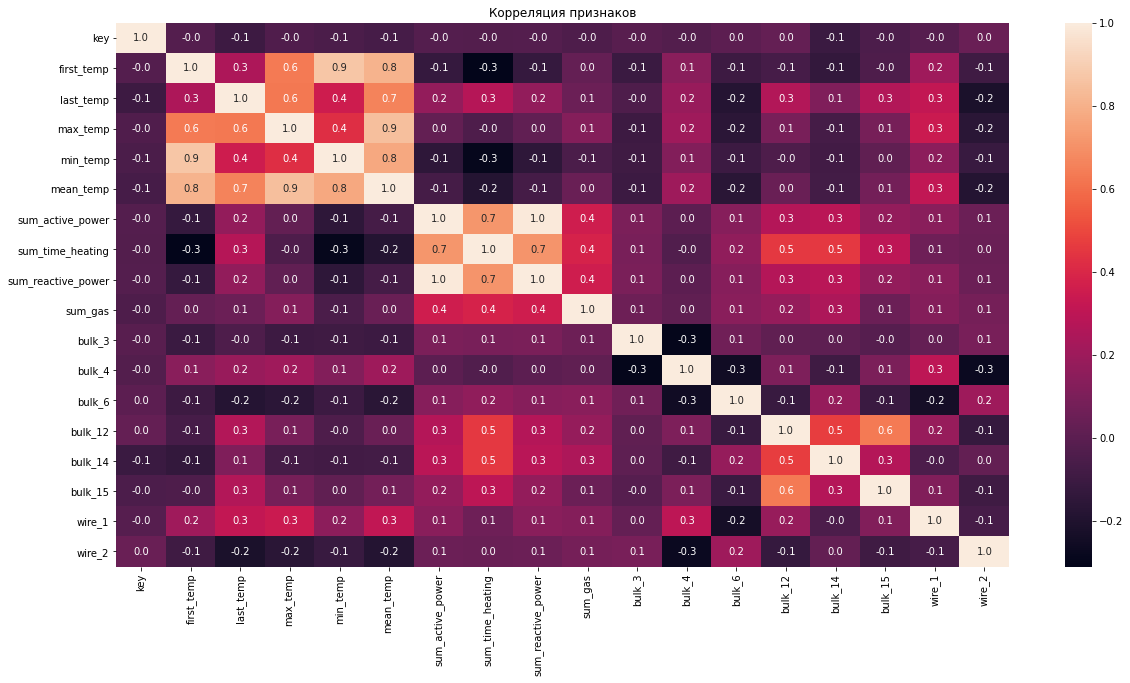

In [64]:
# теперь данные в итоговом датасете в порядке и мы можем изучить корреляцию признаков
corr = data_all.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, fmt=".1f")
plt.title('Корреляция признаков')
plt.show()

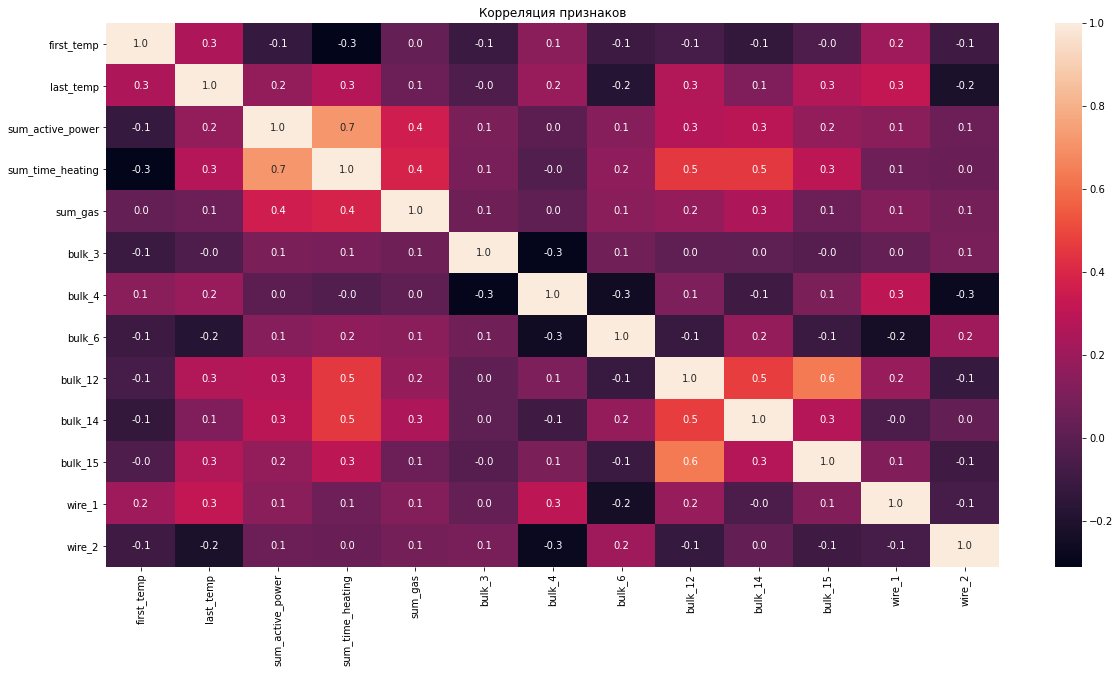

In [65]:
# удалим признаки с высокой корреляцией, которые могут испортить обучение моделей
data_all_new = data_all.drop(['key', 'max_temp', 'min_temp', 'mean_temp', 'sum_reactive_power'], axis=1)

# и снова построим карту
corr_new = data_all_new.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr_new, annot=True, fmt=".1f")
plt.title('Корреляция признаков')
plt.show()

In [66]:
data_all_new

,first_temp,last_temp,sum_active_power,sum_time_heating,sum_gas,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,wire_1,wire_2
0,1571,1613,3.036730,1098,29.749986,0,43,0,206,150,154,60.059998,0.00000
1,1581,1602,2.139408,811,12.555561,0,73,0,206,149,154,96.052315,0.00000
2,1596,1599,4.063641,655,28.554793,0,34,0,205,152,153,91.160157,0.00000
3,1601,1625,2.706489,741,18.841219,0,81,0,207,153,154,89.063515,0.00000
4,1576,1602,2.252950,869,5.413692,0,78,0,203,151,152,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,1570,1591,3.168133,723,7.125735,21,0,0,256,129,223,89.150879,0.00000
2324,1554,1591,4.174918,940,9.412616,0,63,0,256,129,226,114.179527,0.00000
2325,1571,1589,3.605239,569,6.271699,0,85,0,230,124,226,94.086723,9.04800
2326,1591,1594,3.202310,750,14.953657,90,0,0,206,129,207,118.110717,0.00000


### Выводы:

*Нам удалось из пяти разрозненных датасетов составить общий датасет с ключевыми признаками:*
 - first_temp - первый замер температуры партии
 - last_temp - последний замер температуры (`ключевой признак`)
 - sum_active_power - суммарная активная мощность
 - sum_time_heating - суммарное время нагрева
 - sum_gas объем потребленного газа
 - bulk_3 - объем сыпучего материала №3
 - bulk_4 - объем сыпучего материала №4
 - bulk_6 - объем сыпучего материала №6
 - bulk_12 - объем сыпучего материала №12
 - bulk_14 - объем сыпучего материала №14
 - bulk_15 - объем сыпучего материала №15
 - wire_1 - объем проволочного материала №1
 - wire_2 - объем проволочного материала №2
 
*Датасет полностью чист от ошибок и теберь мы можем переходить к разбиению на обучаюшую и тестовую выборки с дальнейшим построением моделей машинного обучения.*

## Обучение моделей

In [67]:
# выделим целевой признак и разделим датасет на обучающую и тестовую выборки
features = data_all_new.drop(['last_temp'], axis=1)
target = data_all_new['last_temp']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                            random_state=80523)

In [68]:
# сделаем масштамбирование признаков
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

In [69]:
# посмотрим на размер выборок
print('Размер обучающей выборки:', features_train.shape)
print('Размер тестовой выборки:', features_test.shape)

Размер обучающей выборки: (1745, 12)
Размер тестовой выборки: (582, 12)


### Модель LinearRegression

In [70]:
%%time

# построим модель линейной регрессии
parameters_lr = {'fit_intercept': [True],
                 'n_jobs': [-1, 0, 1],
                 'normalize': [True, False]}
model_lr = LinearRegression()
grid_lr = GridSearchCV(estimator=model_lr, param_grid=parameters_lr, scoring='neg_mean_absolute_error', cv=5)
grid_lr.fit(features_train, target_train)
best_param_lr = grid_lr.best_params_
mae_lr = cross_val_score(model_lr, 
                              features_train, 
                              target_train, 
                              cv=5,
                              scoring='neg_mean_absolute_error').mean()
print('Лучшие параметры для линейной регрессии:', best_param_lr)
print('\n')
print('Среднее MAE на обучающей выборке:', mae_lr)
print('\n')

Лучшие параметры для линейной регрессии: {'fit_intercept': True, 'n_jobs': -1, 'normalize': True}


Среднее MAE на обучающей выборке: -6.67928460622043


CPU times: user 156 ms, sys: 231 ms, total: 387 ms
Wall time: 329 ms


### Модель DecisionTreeRegressor

In [71]:
%%time

# построим модель дерева решений
parameters_dtr = {'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
                  'splitter': ['best', 'random'],          
                  'random_state': [80523],
                  'max_depth': [3, 5, 7, 10],
                  'max_features': ['auto', 'sqrt', 'log2', None]}
model_dtr = DecisionTreeRegressor()
grid_dtr = GridSearchCV(estimator=model_dtr, param_grid=parameters_dtr, scoring='neg_mean_absolute_error', cv=5)
grid_dtr.fit(features_train, target_train)
best_param_dtr = grid_dtr.best_params_
mae_dtr = cross_val_score(model_dtr, 
                              features_train, 
                              target_train,
                              n_jobs=-1,
                              cv=5,
                              scoring='neg_mean_absolute_error').mean()
print('Лучшие параметры для дерева решений:', best_param_dtr)
print('\n')
print('Среднее MAE на обучающей выборке:', mae_dtr)
print('\n')

Лучшие параметры для дерева решений: {'criterion': 'friedman_mse', 'max_depth': 7, 'max_features': 'auto', 'random_state': 80523, 'splitter': 'best'}


Среднее MAE на обучающей выборке: -8.632091690544412


CPU times: user 1.64 s, sys: 63.7 ms, total: 1.71 s
Wall time: 1.73 s


### Модель RandomForestRegressor

In [75]:
%%time

# построим модель случайного леса
parameters_rf = {'random_state': [80523],
                 'max_depth': [3, 5, 7, 10],
                 'n_estimators': [25, 50, 100],
                 'max_features': ['sqrt', 'log2', None]}
model_rf = RandomForestRegressor()
grid_rf = GridSearchCV(estimator=model_rf, param_grid=parameters_rf, scoring='neg_mean_absolute_error', cv=5)
grid_rf.fit(features_train, target_train)
best_param_rf = grid_rf.best_params_
mae_rf = cross_val_score(model_rf, 
                              features_train, 
                              target_train,
                              n_jobs=-1,
                              cv=5,
                              scoring='neg_mean_absolute_error').mean()
print('Лучшие параметры для случаного леса:', best_param_rf)
print('\n')
print('Среднее MAE на обучающей выборке:', mae_rf)
print('\n')

Лучшие параметры для случаного леса: {'max_depth': 10, 'max_features': None, 'n_estimators': 100, 'random_state': 80523}


Среднее MAE на обучающей выборке: -6.389484240687681


CPU times: user 32.7 s, sys: 144 ms, total: 32.9 s
Wall time: 32.9 s


**Вывод:** Итак мы провели обучение трех моделей. Лучший показатель МАЕ был у модели случайного леса - **RandomForestRegressor**. МАЕ данной модели на обучающей выборке составил **6,39** , при следующих параметрах: `{'max_depth': 10, 'max_features': None, 'n_estimators': 100, 'random_state': 80523}`. Теперь приступим к тестированию лучшей модели на новых данных.

#### Тестирование модели RandomForestRegressor на тестовой выборке

In [76]:
# используем лучшие параметры модели для ее тестирования
model_rf.set_params(**best_param_rf)
model_rf.fit(features_train, target_train)
predict_rf = model_rf.predict(features_test)
mae_rf_on_test = mean_absolute_error(target_test, predict_rf)
print('MAE модели RandomForestRegressor на тестовой выборке:', mae_rf_on_test)

MAE модели RandomForestRegressor на тестовой выборке: 6.371833744327021


**Вывод:** На тестовой выборке наша модель показала результат сопоставимый с результатом на обучающей выборке. **МАЕ на тесте составила 6,37 .**

#### Анализ факторов влияния на модель

In [77]:
explainer = shap.Explainer(model_rf, feature_names=data_all_new.columns)
shap_test = explainer(features_test)

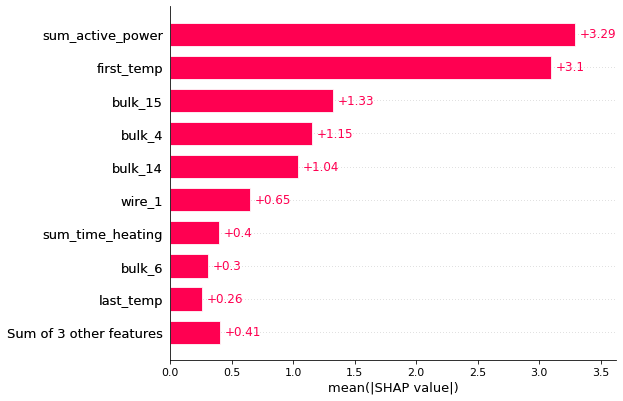

In [78]:
shap.plots.bar(shap_test)

Как мы можем видеть на графике наибольшее значение для модели представляют данные о суммарной активной мощности и начальной температуре. Меньше всего влияния, за исключением целевого признака, оказали суммарное время нагрева и объем сыпучего материала №6.

### Выводы:

Мы построили три модели машинного обучения для задачи регресии. Лучший результат в обучении показала модель случайного леса - `RandomForestRegressor`. На тестовой выборке наша модель показала результат сопоставимый с результатом на обучающей выборке. **МАЕ на тесте составила 6,37** . Это означает, что модель, если она будет одобрена и принята на металлургический комбинат ООО «Так закаляем сталь», сможет предсказывать температуру стали с погрешностью ~ 6,37 градусов. 

Если учесть, что минимальная входная температура в датасете составляла 1191 градус, то размер погрешности будет составлять 6,37 / 1 191 = 0,0053 или 0,5%. Т.о. **нам удалось создать модель способную предсказывать с точностью равной 99,5%.**

## Отчет по проекту

В процессе проведения исследования нам удалось выполнить все намеченные этапы плана:
 - Проведение исследовательского анализа данных
 - Проведение очистки данных
 - Создание общего датасета из ключевых признаков
 - Проверка признаков на мультиколлинеарность
 - Выделение целевого признака
 - Разбиение датасета на выборки: обучающую и тестовую
 - Создание моделей машинного обучения
 - Выбор лучшей модели, ее тестирование и анализ ключевых признаков
 - Формирование выводов

При работе с данными мы столкнулись со следующими сложностями: пропуски в данных, выбросы, некорректные данные (аномалии). С помощью средств библиотек `pandas` и `matplotlib` нам удалось выявить все неточности, выбросы и их устранить.

Ключевыми этапами в решении поставленной задачи являлись: формирование единого датасета с ключевыми признаками, на котором мы бы проводили обучение моделей, а также создание моделей машинного обучения и подбор их гиперпараметров.

В итоге мы построили три модели машинного обучения для задачи регресии. Лучший результат в обучении показала модель случайного леса - `RandomForestRegressor`. На тестовой выборке наша модель показала результат сопоставимый с результатом на обучающей выборке. **Средняя абсолютная ошибка (МАЕ) на тесте составила 6,37**.

Наша лучшая модель обучалась на датасете состоящем из следующих признаков:

 - first_temp - первый замер температуры партии
 - last_temp - последний замер температуры `(целевой признак)`
 - sum_active_power - суммарная активная мощность
 - sum_time_heating - суммарное время нагрева
 - sum_gas объем потребленного газа
 - bulk_3 - объем сыпучего материала №3
 - bulk_4 - объем сыпучего материала №4
 - bulk_6 - объем сыпучего материала №6
 - bulk_12 - объем сыпучего материала №12
 - bulk_14 - объем сыпучего материала №14
 - bulk_15 - объем сыпучего материала №15
 - wire_1 - объем проволочного материала №1
 - wire_2 - объем проволочного материала №2
 
Проведя анализ факторов влияния на модель, сделанного с помошью средств библиотеки `shap`, мы увидели, что на результат модели наибольшее влияние оказали два признака. Это начальная температура и суммарная активная мощность. С точки срения производственных процессов, такой результат является логичным. Чем меньше начальная температура, тем больше энергии потребуется на нагрев сплава находящегося в ковше и наоборот.

Наша лучшая модель `RandomForestRegressor` - модель "случайного леса" - добилась лучшего значения средней абсолютной ошибки (МАЕ равном 6,37), при следующих гиперпараметрах: 

`{'max_depth': 10, 'max_features': None, 'n_estimators': 100, 'random_state': 80523}`. 

**В качестве предложений по улучшению модели можно рассмотреть следующие варианты:** <br>

1. Генерация дополнительных метрик и признаков вроде средней активной мощности или средней реактивной мощности, изучение их влияния на модель и финальную метрику.<br>  
<br>  
2. Сбор и изучение дополнительных данных о составе сплава, используемом газе, итоговом времени на технологические процессы и др. Чем больше данных соберем и проанализируем, тем больше признаков сможем найти и предоставить модели для обучения. Соответственно результаты модели изменятся (количество перейдет в качество). <br>
<br>  
3. Рассмотреть использование других моделей машинного обучения. Например построить модели градиентного бустинга - LightGBM или XGBoost и подобрать к ним гиперпараметры. Данные модели способны улучшить результат. <br>

*Подводя итог исследованию можно сказать, что цель проекта была упешно достигнута. Металлургический комбинат для уменьшения потребление электроэнергии может использовать нашу модель, которая предсказывает температуру стали.*